[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/Linear_Regression_RNA.ipynb)

# Clone github repo

In [ ]:
!git clone https://github.com/pachterlab/OP_2025.git
%cd /content/OP_2025/

# Download Data

In [ ]:
!mkdir omics_adata
!wget -O omics_adata/rat_RNA_meta.h5ad https://data.caltech.edu/records/j57wp-0pp06/files/rat_RNA_meta.h5ad?download=1


--2025-07-02 12:03:20--  https://data.caltech.edu/records/j57wp-0pp06/files/rat_RNA_meta.h5ad?download=1
Resolving data.caltech.edu (data.caltech.edu)... 35.155.11.48
Connecting to data.caltech.edu (data.caltech.edu)|35.155.11.48|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: /login/?next=%2Frecords%2Fj57wp-0pp06%2Ffiles%2Frat_RNA_meta.h5ad%3Fdownload%3D1 [following]
--2025-07-02 12:03:20--  https://data.caltech.edu/login/?next=%2Frecords%2Fj57wp-0pp06%2Ffiles%2Frat_RNA_meta.h5ad%3Fdownload%3D1
Reusing existing connection to data.caltech.edu:443.
HTTP request sent, awaiting response... 200 OK
Length: 4942 (4.8K) [text/html]
Saving to: ‘omics_adata/rat_RNA_meta.h5ad’

omics_adata/rat_RNA 100%[===================>]   4.83K  --.-KB/s    in 0s      

2025-07-02 12:03:21 (36.3 MB/s) - ‘omics_adata/rat_RNA_meta.h5ad’ saved [4942/4942]



# Install Packages

In [ ]:
!pip install -qr requirements.txt 

In [ ]:
import os, sys
sys.path.append('analysis_scripts')
import anndata
import numpy as np
import pandas as pd
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn.linear_model 
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from rat_friend import *

In [13]:
color_dict = {'male': '#E07F80',
            'female': '#317EC2'
}

color_opts =  np.array([
    "#D55E00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#E69F00", "#CC79A7", "#666666", "#AD7700", "#1C91D4", "#007756", "#D5C711", "#005685",
    "#A04700", "#B14380", "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71", "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C", "#FFCB57", "#9AD2F2",
    "#2CFFC6", "#F6EF8E", "#38B7FF", "#FF9B4D", "#E0AFCA", "#A3A3A3", "#8A5F00", "#1674A9", "#005F45", "#AA9F0D", "#00446B", "#803800", "#8D3666",
    "#3D3D3D"
])
tissues = ['ADRNL','BAT','BLOOD','COLON','CORTEX','HEART','HIPPOC','HYPOTH',
 'KIDNEY','LIVER', 'LUNG','OVARY','SKM-GN','SKM-VL','SMLINT','SPLEEN','TESTES','VENACV','WAT']
for x in range(len(tissues)):
    color_dict[tissues[x]] = color_opts[x]

color_dict

{'male': '#E07F80',
 'female': '#317EC2',
 'ADRNL': '#D55E00',
 'BAT': '#56B4E9',
 'BLOOD': '#009E73',
 'COLON': '#F0E442',
 'CORTEX': '#0072B2',
 'HEART': '#E69F00',
 'HIPPOC': '#CC79A7',
 'HYPOTH': '#666666',
 'KIDNEY': '#AD7700',
 'LIVER': '#1C91D4',
 'LUNG': '#007756',
 'OVARY': '#D5C711',
 'SKM-GN': '#005685',
 'SKM-VL': '#A04700',
 'SMLINT': '#B14380',
 'SPLEEN': '#4D4D4D',
 'TESTES': '#FFBE2D',
 'VENACV': '#80C7EF',
 'WAT': '#00F6B3'}

# Initial Data Loading

In [ ]:
og_adata = anndata.read_h5ad("omics_adata/rat_RNA_meta.h5ad")

og_adata.obs.time = og_adata.obs.time.astype('int')

# normalized but not logged due to the meathematical assumptions underlying linear regression 
sc.pp.normalize_total(og_adata)

og_adata.layers["counts"] = og_adata.X.copy()
og_adata

AnnData object with n_obs × n_vars = 861 × 24770
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'gene_id', 'has_U_tr', 'eff_len', 'mt', 'ensembl_transcript_id', 'description', 'ensembl_gene_id', 'X3', 'X5', 'X6', 'X7', 'X8'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

# Linear Regression

## Reshaping Data by concatanating by individual

In [15]:
X, y, z = data_reshaper_omic(og_adata, tiss_list = og_adata.obs.tissue.unique())
y = y.reset_index(drop=True)

SKM-GN
HYPOTH
CORTEX
HIPPOC
WAT
BAT
BLOOD
SPLEEN
SMLINT
COLON
ADRNL
KIDNEY
SKM-VL
HEART
LIVER
LUNG


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Running Ridge Regression

In [17]:
np.random.seed(0)

# subset each group of time and sex into 2/3 train, 1/3 test
train_filter = y.reset_index(drop=True)[['nid', 'time', 'sex']].groupby('nid',observed=False).agg(lambda x: x.value_counts().index[0])
train_nids = train_filter.groupby(['time', 'sex'],observed=False).apply(lambda x: x.sample(1+np.round(len(x)/3).astype('int')),include_groups=False).index.get_level_values(2).tolist()
ref_mask = [x in train_nids for x in y.nid]
X_train = X[ref_mask]
X_test = X[list(~np.array(ref_mask))]
y_train = y[ref_mask]
y_test = y[list(~np.array(ref_mask))]

# instantiate the model (using the default parameters)
model = sklearn.linear_model.Ridge(random_state=0)

# fit the model with data
model.fit(X_train, y_train.time)

y_pred = model.predict(X_test)
big_ccc = get_CCC(y_test.time.astype('int'), y_pred)
big_r2 = sklearn.metrics.r2_score(y_test.time.astype('int'), y_pred)

In [18]:
# get overview of groupings
y[['nid', 'time', 'sex']].groupby(['time', 'sex'],observed=False).count()

nid
time sex        
0    female    3
     male      3
1    female    3
     male      3
2    female    4
     male      3
4    female    3
     male      5
8    female    5
     male      4

Convert results into a DataFrame for easier graphing

In [19]:
test_df = pd.DataFrame({'prediction' : y_pred,
                            'actual' : y_test.time,
                            'Sex': y_test.sex
                             })
test_df.index = y_test.nid
test_df['Subset'] = 'test'
train_df = pd.DataFrame({'prediction' : model.predict(X_train),
                            'actual' : y_train.time,
                            'Sex': y_train.sex
                             })
train_df.index = y_train.nid
train_df['Subset'] = 'train'


Save Results

In [20]:
sig_coeff = pd.DataFrame({'coeff' : model.coef_.tolist(),
                          'abs_coeff': np.abs(model.coef_.tolist()),
                            'feature' : z.index.tolist(),
                          'tissue' : z.tissue.tolist(),
                         'feature_num' : range(0, z.shape[0])})
sig_coeff.to_csv('linear_regression_time_coeffs.csv', index=False)
pd.concat([test_df, train_df]).to_csv('lin_reg_results.csv')
sig_coeff.sort_values(by='abs_coeff',ascending=False).head(10)

,coeff,abs_coeff,feature,tissue,feature_num
123543,-0.000009,0.000009,ENSRNOG00000013552_BAT,BAT,123543
330245,0.000009,0.000009,ENSRNOG00000013552_LIVER,LIVER,330245
280460,0.000007,0.000007,ENSRNOG00000004583_SKM-VL,SKM-VL,280460
130547,-0.000007,0.000007,ENSRNOG00000033299_BAT,BAT,130547
140100,-0.000007,0.000007,ENSRNOG00000001633_BLOOD,BLOOD,140100
77876,-0.000007,0.000007,ENSRNOG00000016275_HIPPOC,HIPPOC,77876
130754,0.000006,0.000006,ENSRNOG00000034234_BAT,BAT,130754
1865,0.000006,0.000006,ENSRNOG00000003897_SKM-GN,SKM-GN,1865
344314,-0.000006,0.000006,ENSRNOG00000067602_LIVER,LIVER,344314
95317,-0.000006,0.000006,ENSRNOG00000003897_WAT,WAT,95317


## Graph Results

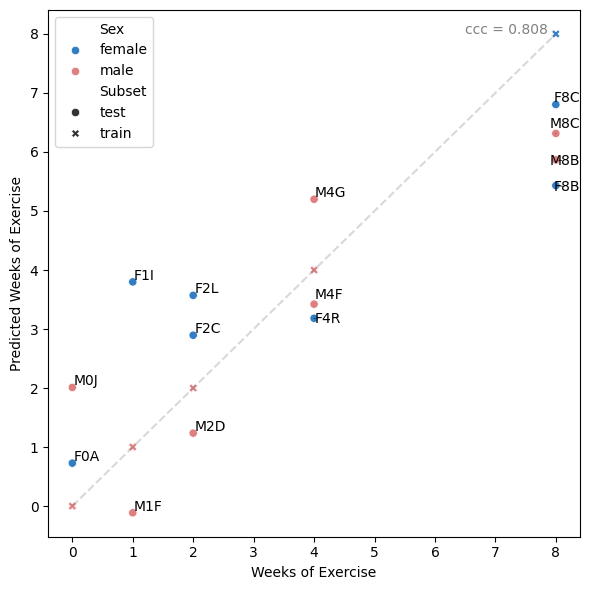

0.8084790714943838 0.7167844321710413


In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(pd.concat([test_df, train_df]), x = 'actual', y = 'prediction', hue = 'Sex', style = 'Subset',
                   palette = color_dict)
plt.plot([0, 8], [0, 8], color = 'grey', alpha = .3, linestyle='--')
plt.text(6.5, 8, f'ccc = {round(big_ccc, 3)}', c = 'grey')
plt.tight_layout()
plt.xlabel('Weeks of Exercise')
plt.ylabel('Predicted Weeks of Exercise')
from adjustText import adjust_text
texts=[]
for i,r in test_df.iterrows():
    texts.append(plt.text(x=r['actual'],y=r['prediction'],s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
plt.savefig(f'figures_final/fig_1d.png')
plt.show()
print(big_ccc, big_r2)

# Linear Regression with Individual Tissues

## Subset by Tissue and Calculate Regression

In [11]:
tiss_list = []
ccc_list = []
r2_list = []

result_df = pd.DataFrame({'Predicted Weeks of Exercise':[],
                       'Weeks of Exercise':[],
                       'tissue':[],
                          'sex':[],
                       'ccc':[]
                       })

for tiss in og_adata.obs.tissue.unique():
    # use only tissues with samples at all time points/sexes
    if tiss not in ['TESTES', 'OVARY','VENACV']:
        X, y, z = data_reshaper_omic(og_adata, tiss_list = [tiss])
        np.random.seed(0)
        
        train_filter = y.reset_index(drop=True)[['pid', 'time', 'sex']].groupby('pid',observed=False).agg(lambda x: x.value_counts().index[0])
        train_pids = train_filter.groupby(['time', 'sex'],observed=False).apply(lambda x: x.sample(3),include_groups=False).index.get_level_values(2).tolist()
        ref_mask = [x in train_pids for x in y.pid]
        
        
        X_train = X[ref_mask]
        X_test = X[list(~np.array(ref_mask))]
        y_train = y[ref_mask]
        y_test = y[list(~np.array(ref_mask))]
        
        # instantiate the model (using the default parameters)
        model = sklearn.linear_model.Ridge(random_state=5)
        
        # fit the model with data
        model.fit(X_train, y_train.time)
        
        y_pred = model.predict(X_test)
        tiss_ccc = get_CCC(y_test.time.astype('int'), y_pred)
        tiss_r2 = sklearn.metrics.r2_score(y_test.time.astype('int'), y_pred)
        
        test_df = pd.DataFrame({'Predicted Weeks of Exercise' : y_pred,
                            'Weeks of Exercise' : y_test.time,
                            'sex': y_test.sex,
                             })
        test_df.index = y_test.nid
        test_df['Subset'] = 'test'
        train_df = pd.DataFrame({'Predicted Weeks of Exercise' : model.predict(X_train),
                                    'Weeks of Exercise' : y_train.time,
                                    'sex': y_train.sex,
                                     })
        train_df.index = y_train.nid
        train_df['Subset'] = 'train'
        temp_df = pd.concat([test_df, train_df])
        temp_df['ccc'] = tiss_ccc
        temp_df['tissue'] = tiss
        
        tiss_list += [tiss]
        ccc_list += [tiss_ccc]
        r2_list += [tiss_r2]
        result_df = pd.concat([result_df, temp_df])
result_df.head()

SKM-GN


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_1971973/2539994804.py:57: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  result_df = pd.concat([result_df, temp_df])
/tmp/ipykernel_1971973/2539994804.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty 

HYPOTH


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


CORTEX


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


HIPPOC


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


WAT


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


BAT


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


BLOOD


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SPLEEN


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SMLINT


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


COLON


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


ADRNL


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


KIDNEY


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SKM-VL


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


HEART


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


LIVER


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


LUNG


/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/pandas/core/frame.py:6479: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  new_obj.index = new_index
/home/coakes/miniconda3/envs/rata/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,Predicted Weeks of Exercise,Weeks of Exercise,tissue,sex,ccc,Subset
M4I,3.795446,4.0,SKM-GN,male,0.887439,test
F1A,1.267508,1.0,SKM-GN,female,0.887439,test
F0L,0.521680,0.0,SKM-GN,female,0.887439,test
F0K,-0.557544,0.0,SKM-GN,female,0.887439,test
F8F,8.800447,8.0,SKM-GN,female,0.887439,test


## Plot Results

/tmp/ipykernel_1971973/889671258.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(6, 8, f'ccc = {round(result_df[result_df.tissue == list(g.axes_dict.keys())[key_num]].ccc[0], 3)}', c = 'grey')


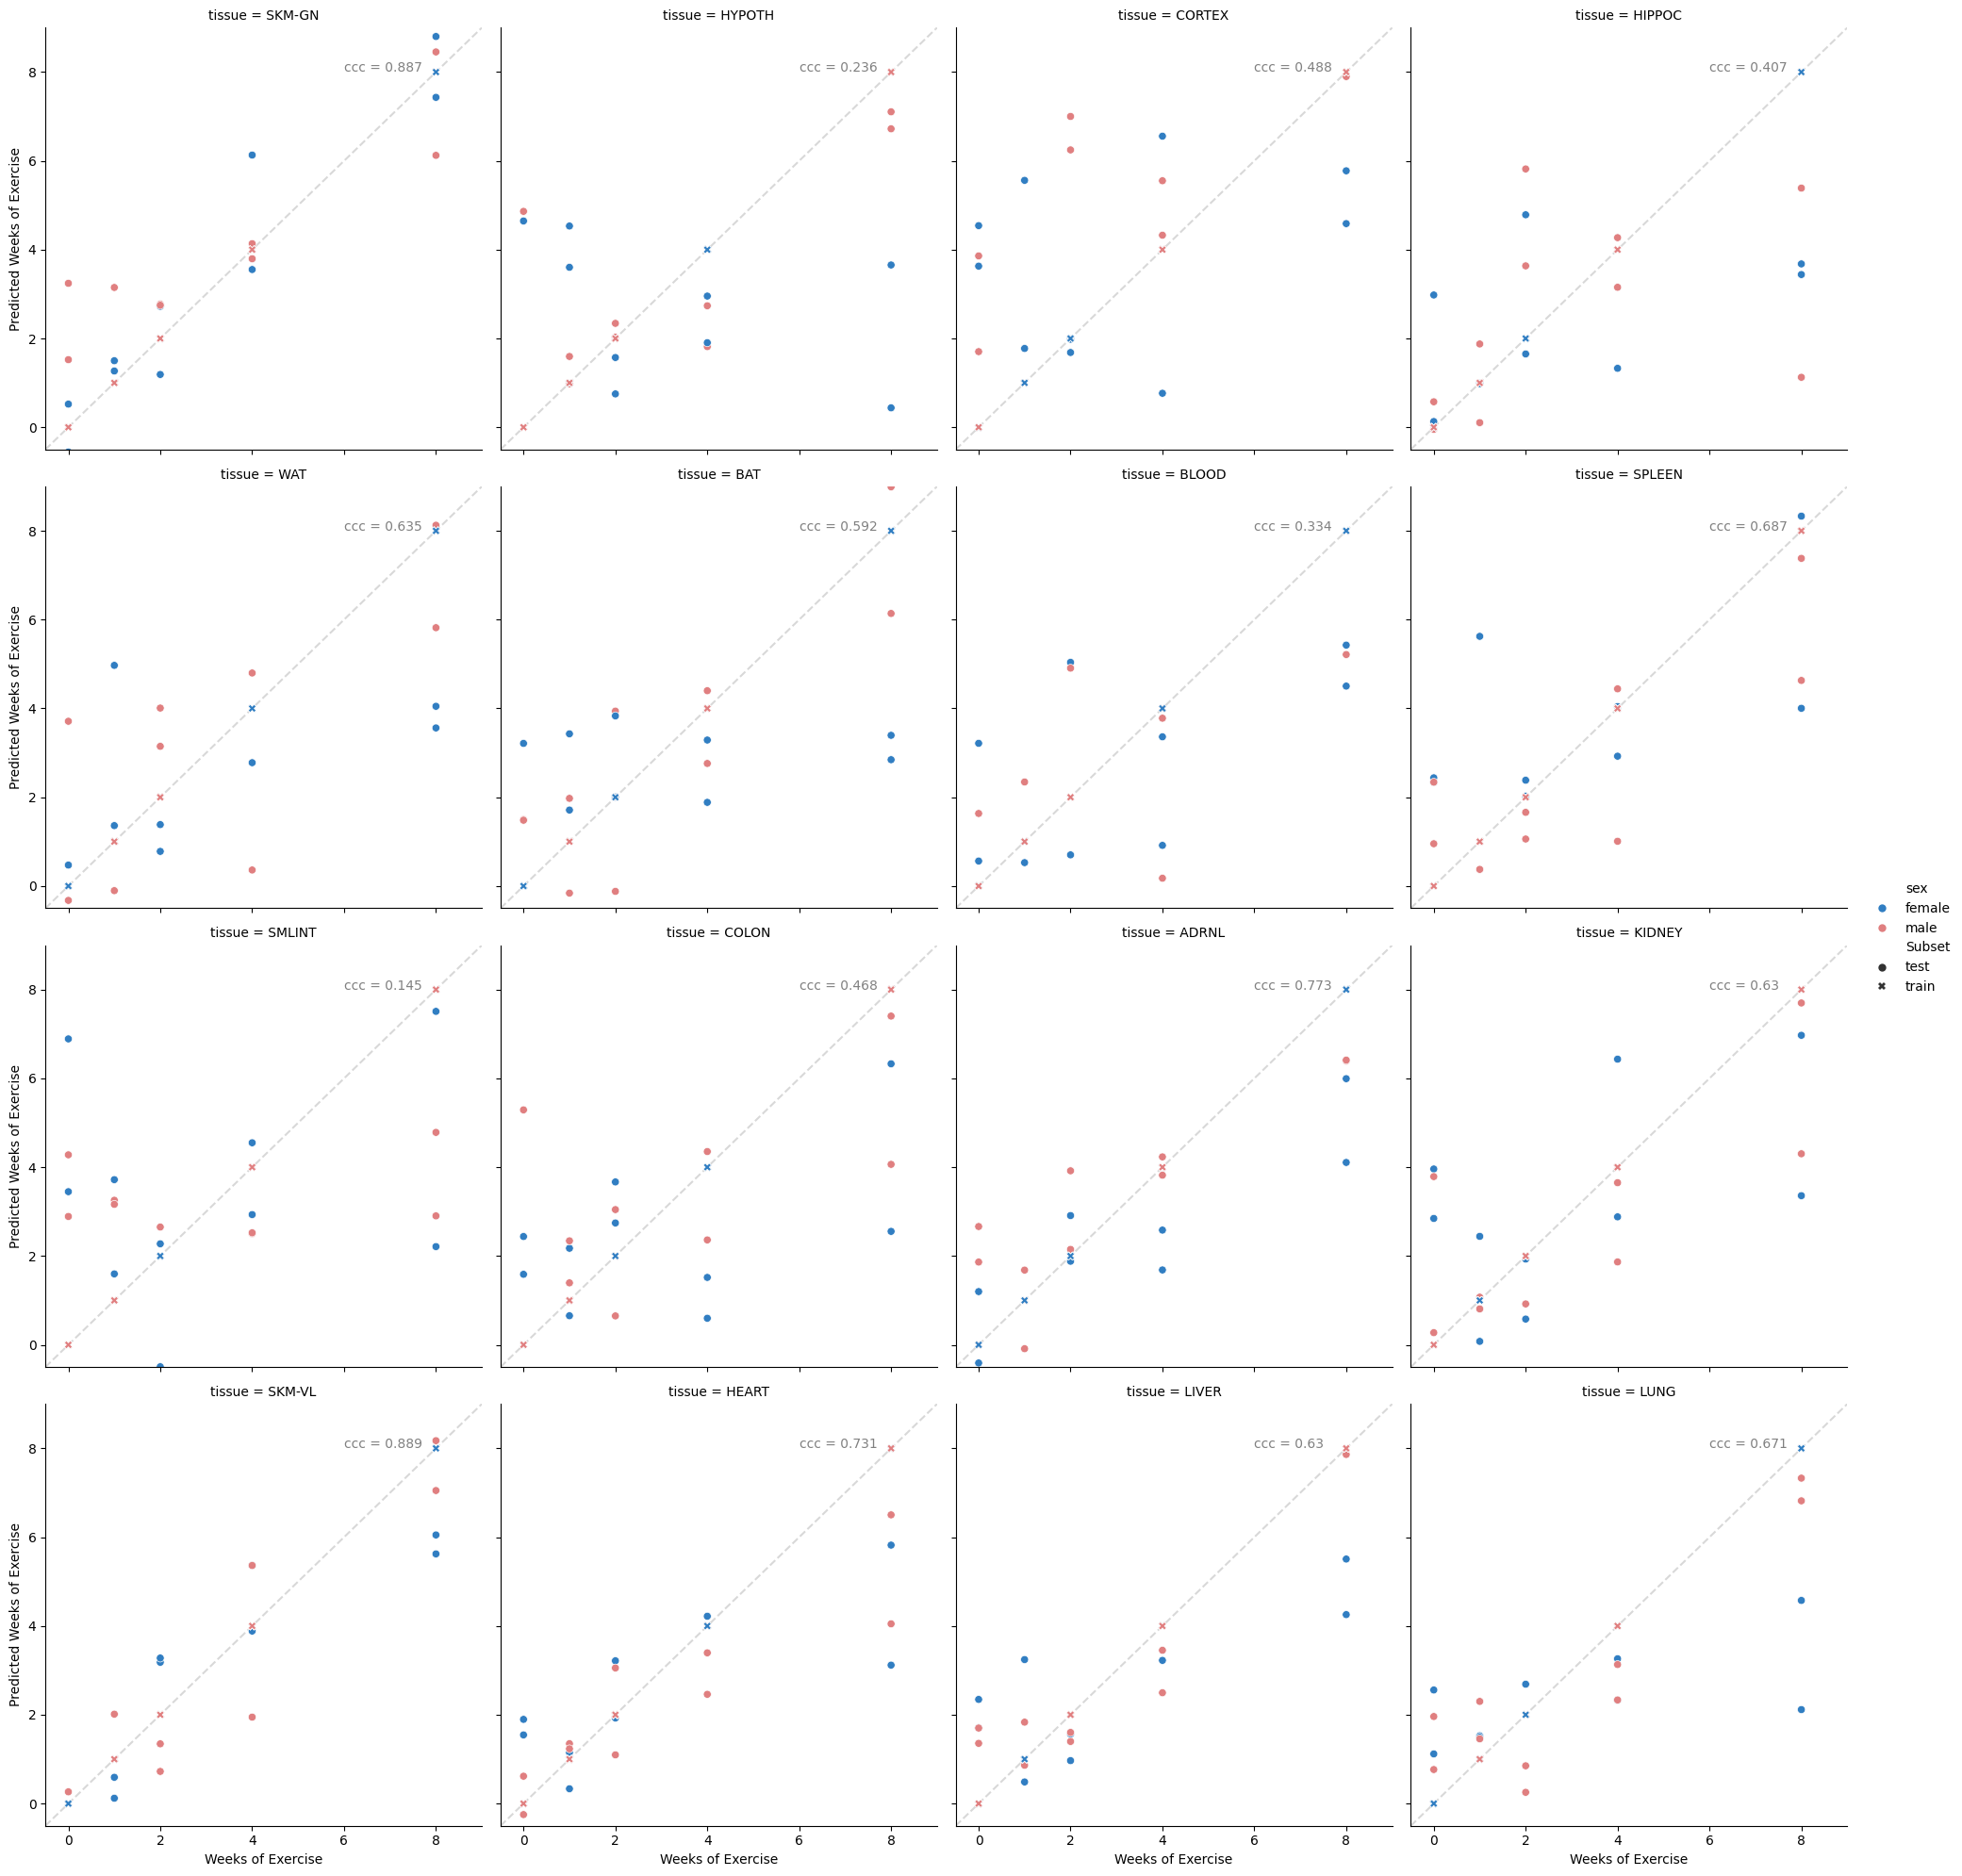

In [12]:
g = sns.relplot(data = result_df, x = 'Weeks of Exercise', y = 'Predicted Weeks of Exercise', hue = 'sex', style = 'Subset',
              col = 'tissue', palette = color_dict, col_wrap=4)
key_num=0
for ax in g.axes_dict.values():
    ax.axline((0, 0), slope=1, color = 'grey', alpha = .3, linestyle='--', zorder=0)
    ax.text(6, 8, f'ccc = {round(result_df[result_df.tissue == list(g.axes_dict.keys())[key_num]].ccc[0], 3)}', c = 'grey')
    key_num += 1
g.set(xlim=(-.5, 9), ylim=(-.5, 9))
plt.savefig(f'figures_final/supp_fig_2.png')
plt.show()

In [13]:
con_df = pd.DataFrame({'tissue' : tiss_list,
              'ccc' : ccc_list,
              'r2' : r2_list})
con_df = pd.merge(con_df, sig_coeff[['tissue', 'abs_coeff']].groupby('tissue',observed=False).sum(), on = 'tissue')
con_df['norm_abs'] = con_df['abs_coeff']/con_df['abs_coeff'].sum()*100
con_df.sort_values('ccc')

,tissue,ccc,r2,abs_coeff,norm_abs
8,SMLINT,0.144946,-0.171344,0.000290,4.411815
1,HYPOTH,0.236228,-0.121779,0.000291,4.427995
6,BLOOD,0.334242,-0.364006,0.000409,6.215693
3,HIPPOC,0.407204,0.058066,0.000339,5.153247
9,COLON,0.468499,0.236043,0.000408,6.202930
2,CORTEX,0.487855,-0.004413,0.000266,4.043299
5,BAT,0.591802,0.375734,0.000725,11.028842
11,KIDNEY,0.629674,0.417571,0.000400,6.088794
14,LIVER,0.630135,0.409222,0.000523,7.964333
4,WAT,0.634540,0.389960,0.000575,8.744671


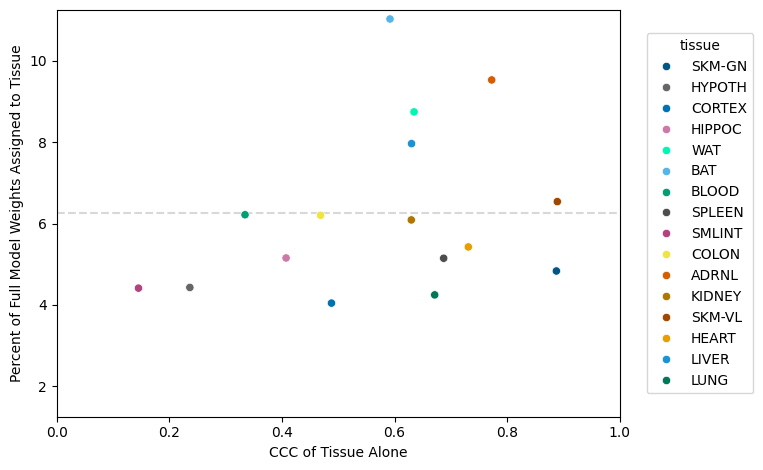

In [ ]:
ax = sns.scatterplot(con_df, x = 'ccc', y = 'norm_abs', hue = 'tissue', palette = color_dict)
plt.tight_layout()
plt.xlabel('CCC of Tissue Alone')
plt.ylabel('Percent of Full Model Weights Assigned to Tissue')
plt.xlim([0, 1])
plt.ylim([100*(1/16 - .05), 100*(1/16 + .05)])
ax.axhline(1/16*100, color = 'gray', alpha = .3, linestyle='--', zorder=0)
sns.move_legend(ax, 'right', bbox_to_anchor=(1.25, .5))
plt.savefig('figures_final/supp_fig_6.png', bbox_inches = 'tight')
plt.show()